(2797, 1)
(2797, 1)
(2797, 1)
(2797, 1)
(2797,)
Number of parameters:  881
Epoch 200 Train 59.80503 Valid 56.09230
Epoch 400 Train 34.63203 Valid 30.06803
Epoch 600 Train 12.34487 Valid 16.85352
Epoch 800 Train 6.57240 Valid 7.93120
Epoch 1000 Train 2.93549 Valid 4.67912
Epoch 1200 Train 3.23443 Valid 2.30825
Epoch 1400 Train 2.32282 Valid 2.07938
Epoch 1600 Train 3.20108 Valid 2.21993
Epoch 1800 Train 1.86189 Valid 3.49824
Epoch 2000 Train 2.04624 Valid 2.26004
Epoch 2200 Train 1.56891 Valid 1.98233
Epoch 2400 Train 1.63428 Valid 1.85431
Epoch 2600 Train 1.48779 Valid 2.05036
Epoch 2800 Train 1.45840 Valid 1.63707
Epoch 3000 Train 1.39048 Valid 1.70959
Epoch 3200 Train 1.43025 Valid 1.60293
Epoch 3400 Train 1.35073 Valid 1.62362
Epoch 3600 Train 1.34008 Valid 1.58090
Epoch 3800 Train 1.34389 Valid 1.61959
Epoch 4000 Train 1.33948 Valid 1.59124
Epoch 4200 Train 1.32745 Valid 1.55215
Epoch 4400 Train 1.32060 Valid 1.54780
Epoch 4600 Train 1.31378 Valid 1.55361
Epoch 4800 Train 1.31276 V

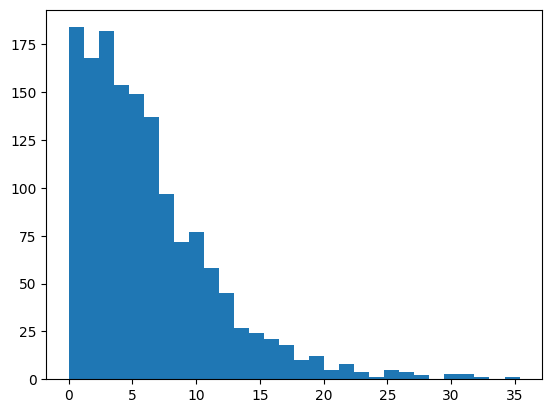

In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import json
import math
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define a fully connected layers model with three inputs (frequency, flux density, duty ratio) and one output (core loss).
        self.layers = nn.Sequential(
            nn.Linear(4, 15),
            nn.ReLU(),
            nn.Linear(15, 25),
            nn.ReLU(),
            nn.Linear(25, 15),
            nn.ReLU(),
            nn.Linear(15, 1),
        )

    def forward(self, x):
        return self.layers(x)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def get_dataset():
    # Load .json Files
    with open('/content/Dataset_tri_N49.json','r') as load_f:
        DATA = json.load(load_f)

    Freq = DATA['Frequency']
    Flux = DATA['Flux_Density']
    Duty = DATA['Duty_Ratio']
    Temperature = DATA['Temperature']
    Power = DATA['Power_Loss']

    # Compute labels
    # There's approximalely an exponential relationship between Loss-Freq and Loss-Flux.
    # Using logarithm may help to improve the training.
    Freq = np.log10(Freq)
    Flux = np.log10(Flux)
    Duty = np.array(Duty)
    Temperature = np.array(Temperature)
    Power = np.log10(Power)

    # Reshape data
    Freq = Freq.reshape((-1,1))
    Flux = Flux.reshape((-1,1))
    Duty = Duty.reshape((-1,1))
    Temperature = Temperature.reshape((-1,1))

    print(np.shape(Freq))
    print(np.shape(Flux))
    print(np.shape(Duty))
    print(np.shape(Temperature))
    print(np.shape(Power))

    temp = np.concatenate((Freq,Flux,Duty, Temperature),axis=1) #Temperature

    in_tensors = torch.from_numpy(temp).view(-1, 4)
    out_tensors = torch.from_numpy(Power).view(-1, 1)

    # # Save dataset for future use
    # np.save("dataset.fc.in.npy", in_tensors.numpy())
    # np.save("dataset.fc.out.npy", out_tensors.numpy())

    return torch.utils.data.TensorDataset(in_tensors, out_tensors)

def get_test():
    with open('/content/Dataset_tri_N49_pretest.json','r') as load_test:
        DATA_TEST = json.load(load_test)

    Freq_t = DATA_TEST['Frequency']
    Flux_t = DATA_TEST['Flux_Density']
    Duty_t = DATA_TEST['Duty_Ratio']
    Temperature_t = DATA_TEST['Temperature']
    Power_t = DATA_TEST['Power_Loss']

    # Compute labels
    # There's approximalely an exponential relationship between Loss-Freq and Loss-Flux.
    # Using logarithm may help to improve the training.
    Freq_t = np.log10(Freq_t)
    Flux_t = np.log10(Flux_t)
    Duty_t = np.array(Duty_t)
    Temperature_t = np.array(Temperature_t)
    Power_t = np.log10(Power_t)

    # Reshape data
    Freq_t = Freq_t.reshape((-1,1))
    Flux_t = Flux_t.reshape((-1,1))
    Duty_t = Duty_t.reshape((-1,1))
    Temperature_t = Temperature_t.reshape((-1,1))

    tmp = np.concatenate((Freq_t, Flux_t, Duty_t, Temperature_t),axis=1)

    in_tensors = torch.from_numpy(tmp).view(-1, 4)
    out_tensors = torch.from_numpy(Power_t).view(-1, 1)

    return torch.utils.data.TensorDataset(in_tensors, out_tensors)


def main():
    # Reproducibility
    random.seed(2)
    np.random.seed(2)
    torch.manual_seed(2)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Hyperparameters
    NUM_EPOCH = 5000
    BATCH_SIZE = 64
    DECAY_EPOCH = 400
    DECAY_RATIO = 0.55
    LR_INI = 0.02

    # Select GPU as default device
    device = torch.device("cuda")

    # Load dataset
    dataset = get_dataset()
    testing = get_test()

    # Split the dataset
    train_size = int(0.8 * len(dataset))
    valid_size = len(dataset)-train_size
    test_size = int(len(testing))
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    test_dataset = testing
    kwargs = {'num_workers': 0, 'pin_memory': True, 'pin_memory_device': "cuda"}
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

    # Setup network
    net = Net().double().to(device)

    # Log the number of parameters
    print("Number of parameters: ", count_parameters(net))

    # Setup optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=LR_INI)

    # Train the network
    for epoch_i in range(NUM_EPOCH):

        # Train for one epoch
        epoch_train_loss = 0
        net.train()
        optimizer.param_groups[0]['lr'] = LR_INI* (DECAY_RATIO ** (0+ epoch_i // DECAY_EPOCH))

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        # Compute Validation Loss
        with torch.no_grad():
            epoch_valid_loss = 0
            for inputs, labels in valid_loader:
                outputs = net(inputs.to(device))
                loss = criterion(outputs, labels.to(device))

                epoch_valid_loss += loss.item()

        if (epoch_i+1)%200 == 0:
          print(f"Epoch {epoch_i+1:2d} "
              f"Train {epoch_train_loss / len(train_dataset) * 1e5:.5f} "
              f"Valid {epoch_valid_loss / len(valid_dataset) * 1e5:.5f}")

    # Save the model parameters
    torch.save(net.state_dict(), "/content/Model_FNN_N49.sd")
    print("Training finished! Model is saved!")


    # Evaluation
    net.eval()
    y_meas = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            y_pred.append(net(inputs.to(device)))
            y_meas.append(labels.to(device))

    y_meas = torch.cat(y_meas, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    print(f"Test Loss: {F.mse_loss(y_meas, y_pred).item() / len(test_dataset) * 1e5:.5f}")

    yy_pred = 10**(y_pred.cpu().numpy())
    yy_meas = 10**(y_meas.cpu().numpy())

    # Relative Error
    Error_re = abs(yy_pred-yy_meas)/abs(yy_meas)*100
    Error_re_avg = np.mean(Error_re)
    Error_re_rms = np.sqrt(np.mean(Error_re ** 2))
    Error_re_max = np.max(Error_re)
    print(f"Relative Error: {Error_re_avg:.8f}")
    print(f"RMS Error: {Error_re_rms:.8f}")
    print(f"MAX Error: {Error_re_max:.8f}")
    plt.hist(Error_re, bins = 30)
    plt.show()

if __name__ == "__main__":
    main()
